### UMAP Encodding

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

In [2]:
print(umap.__version__)

0.5.3


In [3]:
#conda install -c conda-forge kmodes

In [4]:
#pip install plotly

In [5]:
#conda install -c conda-forge lightgbm

In [6]:
#conda install -c conda-forge shap

In [7]:
#conda install -c conda-forge umap-learn

In [8]:
full_data = pd.read_csv("./data/ssbci_catdata.csv")
full_data.drop(labels=["Unnamed: 0","creation_status"], axis=1,inplace=True)
full_data.isna().sum()
full_data.head()

,state_id,program_type,loan_investment_amount,ssbci_original_funds,nonprivate_amount,concurrent_private_financing,borrower_insurance_premium,lender_insurance_premium,guaranteed_amount,collateral_support,...,full_time_employees,naics_code,year_incorporated,jobs_created,jobs_retained,trans_type,CDFI_type,SPY_Close,U_Rate,job_benefit
0,AK,Venture Capital,180000.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,541511,2013,3.0,1.0,VC,VC,152.110001,7.5,4.0
1,AK,Venture Capital,2400000.0,250000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,423930,2012,4.0,0.0,VC,VC,167.509995,7.3,4.0
2,AK,Venture Capital,265000.0,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,541511,2013,2.0,5.0,VC,VC,183.820007,6.7,7.0
3,AK,Venture Capital,199500.0,99750.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,336612,2014,8.0,0.0,VC,VC,181.509995,6.2,8.0
4,AK,Venture Capital,125000.0,62500.0,0.0,125000.0,0.0,0.0,0.0,0.0,...,8.0,451110,2007,8.0,0.0,VC,VC,187.399994,6.3,8.0


In [9]:
full_data.dtypes

state_id                         object
program_type                     object
loan_investment_amount          float64
ssbci_original_funds            float64
nonprivate_amount               float64
concurrent_private_financing    float64
borrower_insurance_premium      float64
lender_insurance_premium        float64
guaranteed_amount               float64
collateral_support              float64
ssbci_recycled_funds            float64
subsequent_private_financing    float64
metro_type                       object
LMI_type                         object
revenue                         float64
full_time_employees             float64
naics_code                        int64
year_incorporated                 int64
jobs_created                    float64
jobs_retained                   float64
trans_type                       object
CDFI_type                        object
SPY_Close                       float64
U_Rate                          float64
job_benefit                     float64


In [10]:
#Get all categorical columns
cols = full_data.columns
#[full_data.columns.get_loc(c) for c in cols if c.dtype == 'oject' ]
cat_features=[full_data.columns.get_loc(c) for c in full_data.columns if full_data.dtypes[c]!='float64']
cat_features

[0, 1, 12, 13, 16, 17, 20, 21]

To evaluate the data visually and to give a visual representatio of the clusters we use UMAP <a href="https://umap-learn.readthedocs.io/en/latest/"> Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)</a> - a dimensionality reduction technique (like PCA or t-SNE) - to embedd the data into 2 dimensions. By doing this, we can create a scatterplot in 2 dimensions that we then color with the fit groups. The steps to do this are:

- Yeo-Johnson transform the numerical columns & One-Hot-Encode the categorical data
- Embed these two column types separately
- Combine the two by conditioning the numerical embeddings on the categorical embeddings as suggested <a href=https://github.com/lmcinnes/umap/issues/58#issuecomment-419682509> here </a>

C:\Users\ljman\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ljman\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ljman\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

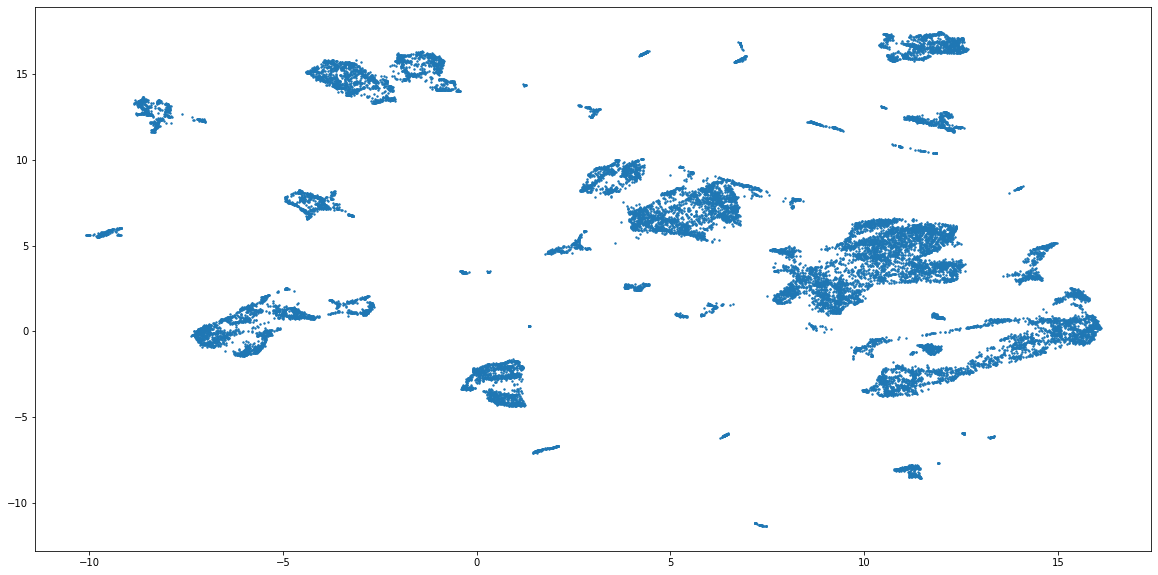

In [11]:
#Preprocessing numerical
from sklearn.preprocessing import PowerTransformer


numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight,)
intersection = umap.umap_.reset_local_connectivity(intersection)
#embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds = {},output_dens = False)

plt.figure(figsize=(20, 10))
#print(*embedding)
plt.scatter(*np.array(embedding)[0].T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [12]:
import plotly.express as px
#fig=px.figure(figsize=(20, 10))
#print(*embedding)
#fig=px.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
#fig.write_html("firstScatter.html")
#fig.show()

### K Means

Because K-Means only works with numerical data, I’ll:

<li>One-Hot-Encode the categorical data
<li>Apply the Yeo-Johnson transformation to the data to make it more Gaussian like
<li>Fit K-Means with several different numbers of clusters.

<b>* Note K-Means will not be used for this particular analysis but is included in the code for later comparison</b>

In [13]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


In [ ]:
#One-Hot-Encoding
data = pd.get_dummies(full_data)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [ ]:
#Actual Clustering
kmeans = KMeans(n_clusters=15).fit(data)
kmeans_labels = kmeans.labels_
pd.Series(kmeans_labels).value_counts()

In [ ]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

### K Prototypes

K Prototypes is a version of K-Means that can deal with categorical data.

- First we will normalize the data numerical data between (-1,1)
- Next we specify the categorical columns which the K-Prototype library can encode

In [14]:
kprot_data = full_data.copy()
#Pre-processing
for c in full_data.select_dtypes(exclude=['object','int64']).columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = cat_features #make sure to specify correct indices

Each cluster is generated with its members and stored in a dicationary with its members and cluster number

In [15]:
#Actual clustering
clusters={}
for n_clust in [4,6, 8,10]:
    kproto = KPrototypes(n_clusters= n_clust, init='Cao', n_jobs = 4)
    clusters[n_clust] = kproto.fit_predict(kprot_data, categorical=categorical_columns)
    #Prints the count of each cluster group
    print(pd.Series(clusters[n_clust]).value_counts())

#Prints the count of each cluster group
#pd.Series(clusters).value_counts()

2    9397
3    6242
0    4646
1    1677
dtype: int64
2    8263
1    5493
5    4243
0    1670
4    1342
3     951
dtype: int64
6    5483
5    4042
7    3128
2    2726
0    2665
4    1660
1    1308
3     950
dtype: int64
4    5210
2    3986
9    2713
7    2071
8    1927
6    1656
0    1309
1    1073
5    1070
3     947
dtype: int64


In [ ]:
#OPTIONAL: Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 25)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=1)
        clusters = kproto.fit_predict(kprot_data, categorical=cat_features)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

### Visual Evaluation

### K Means

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

### K Prototypes

Here I create a plot for each of the cluster groupings to visualize where the members of each group are locataed. Combining this with SHAP and F1 will give a good idea of what is the best number of clusters to choose

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


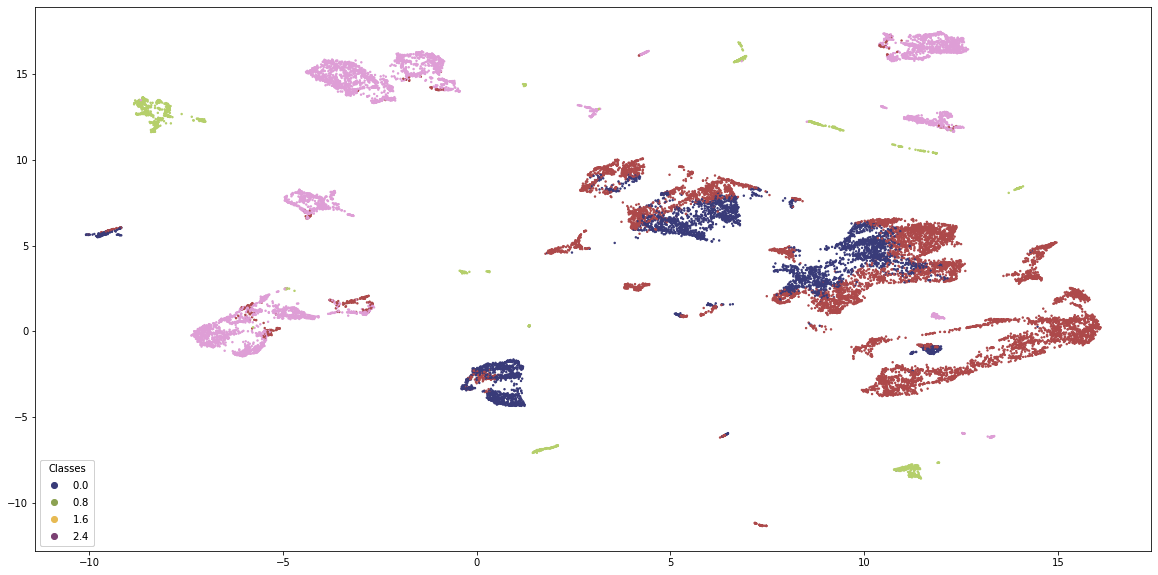

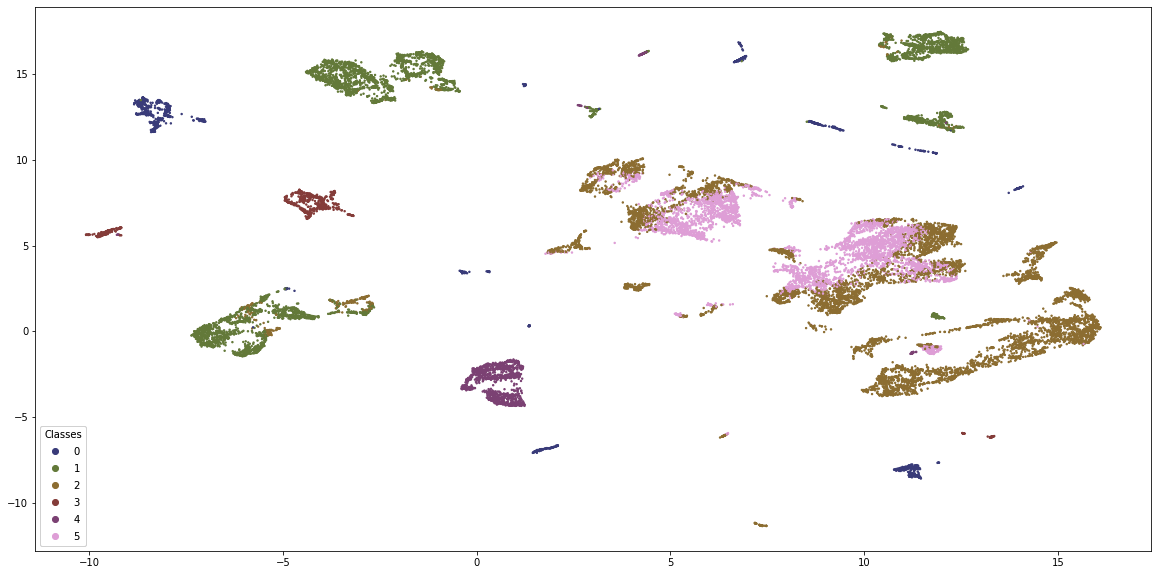

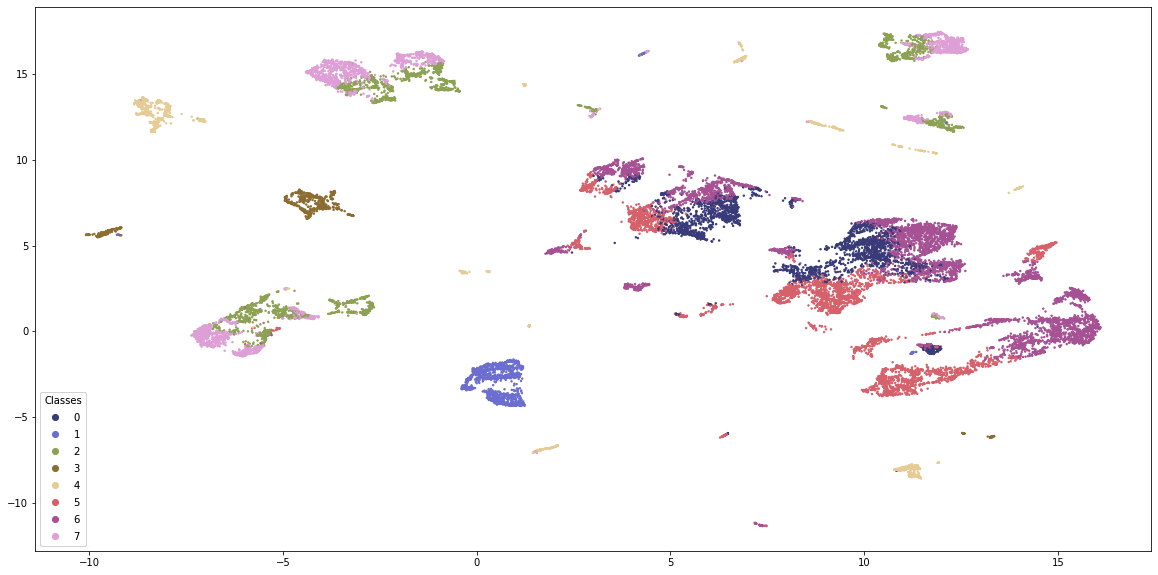

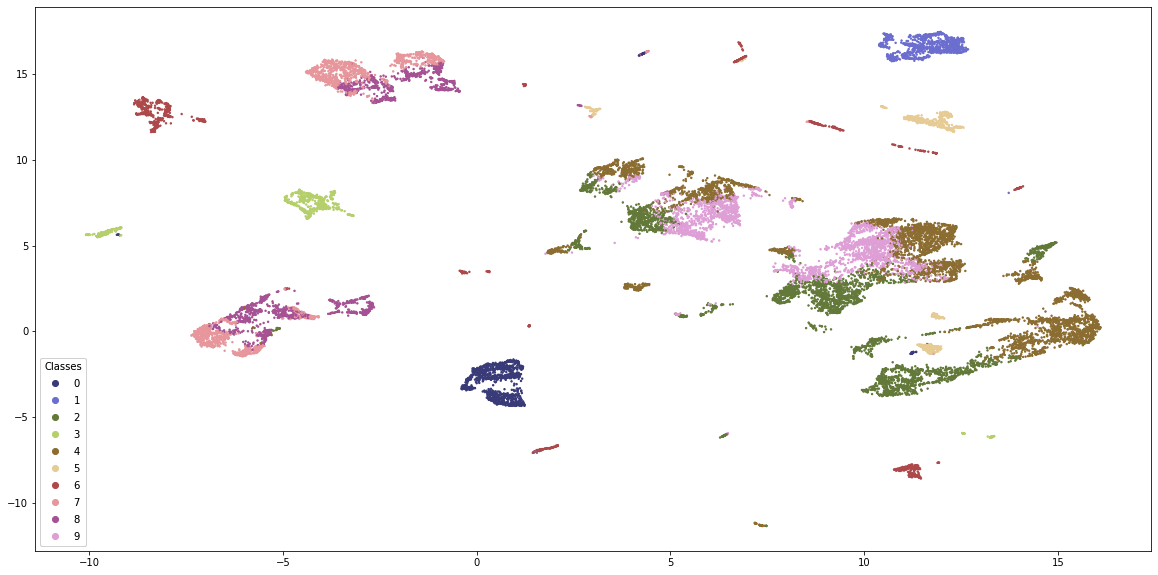

In [16]:
for n, x in clusters.items():
    fig, ax = plt.subplots()
    fig.set_size_inches((20, 10))
    scatter = ax.scatter(np.array(embedding)[0][:, 0], np.array(embedding)[0][:, 1], s=2, c=x, cmap='tab20b', alpha=1.0,)
    # ax[n].set_title=print(f'{n} Clusters')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(num=n),
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)

## Evaluation of Classification

Another comparison method is treating the clusters as labels and building a classification model on top. 

- If the clusters are of high quality, the classification model will be able to predict them with high accuracy. 
- At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. O

We will check the following attributes:
<ul>
<li>Distinctivness of clusters by cross-validated F1 score
<li>Informativness of clusters by SHAP feature importances
</ul>
I will use LightGBM as my classifier because it can use categorical features and you can easily get the SHAP values for the trained models.

In [17]:
#Setting the objects to category 
lgbm_data = full_data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [18]:
lgbm_data.columns

Index(['state_id', 'program_type', 'loan_investment_amount',
       'ssbci_original_funds', 'nonprivate_amount',
       'concurrent_private_financing', 'borrower_insurance_premium',
       'lender_insurance_premium', 'guaranteed_amount', 'collateral_support',
       'ssbci_recycled_funds', 'subsequent_private_financing', 'metro_type',
       'LMI_type', 'revenue', 'full_time_employees', 'naics_code',
       'year_incorporated', 'jobs_created', 'jobs_retained', 'trans_type',
       'CDFI_type', 'SPY_Close', 'U_Rate', 'job_benefit'],
      dtype='object')

### K Means

In [ ]:
#KMeans clusters
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

In [ ]:
#Fit the model
clf_km.fit(lgbm_data, kmeans_labels)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

### K Prototypes

In [19]:
for n,x in clusters.items():
    clf_kp = LGBMClassifier(colsample_by_tree=0.8)
    cv_scores_kp = cross_val_score(clf_kp, lgbm_data, x, scoring='f1_weighted')
    print(f'CV F1 score for K-Prototypes {n} clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes 4 clusters is 0.94119936047242
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes 6 clusters is 0.9643122786856988
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 sc

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


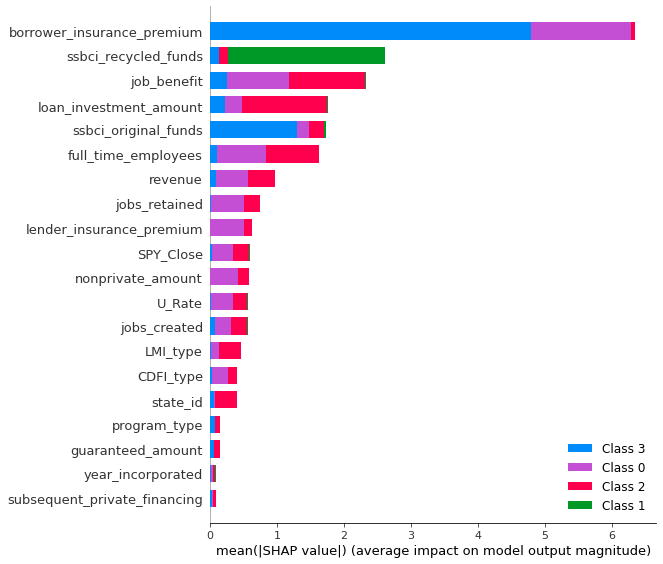

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


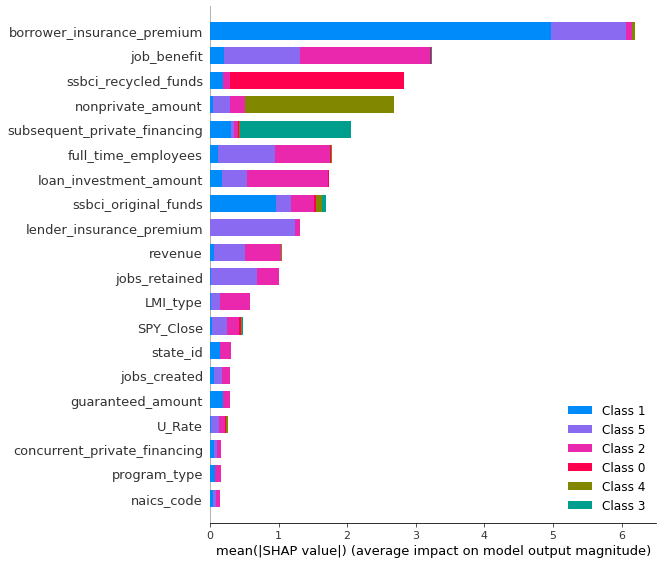

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


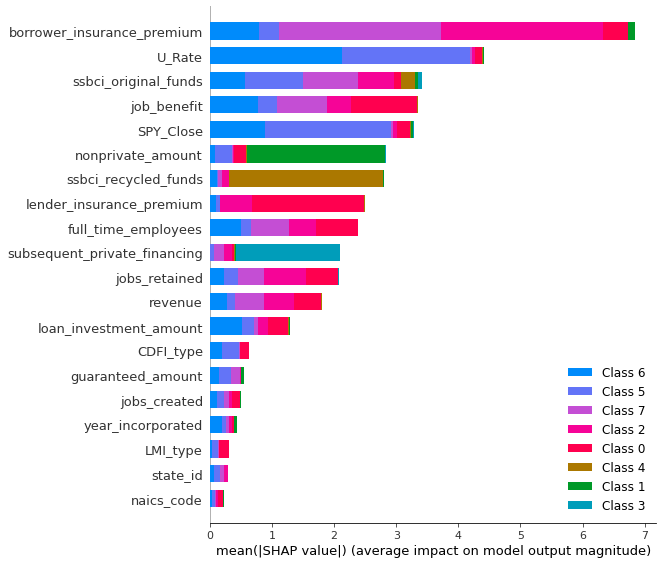

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


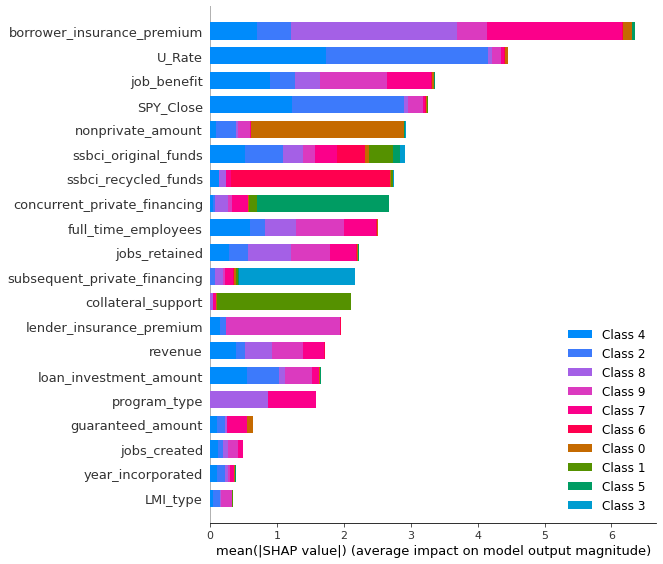

In [20]:
for n in clusters.values():
    clf_kp.fit(lgbm_data, n)
    explainer_kp = shap.TreeExplainer(clf_kp)
    shap_values_kp = explainer_kp.shap_values(lgbm_data)
    shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar") #plot_size=(15, 10))

10 clusters appears to be a good balance between F1 and feature use. I've run this several times and it bounces between 8 and 10.I'll keep the dataset with it's assigned clusters and use it later for comparing predictive models where I use the group assignment as a feature to see if it adds information.

In [21]:
ssbci_data_clusters = full_data.copy()
ssbci_data_clusters['kproto']=clusters[10]

In [22]:
ssbci_data_clusters.to_csv("./data/ssbci_data_withclusters.csv")